# HPDP Assignment 2

## Group Members:
| Name                    | Matric Number |
|-------------------------|---------------|
| **Camily Tang Jia Lei** | A22EC0039     |
| **Ng Shu Yu**           | A22EC0228     |

# Big Data Handling Strategies

## Pandas

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
import os
import shutil
import zipfile
import pandas as pd
import time

# Upload kaggle.json
uploaded = files.upload()

# Setup Kaggle API key
kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)
shutil.move("kaggle.json", os.path.join(kaggle_dir, "kaggle.json"))
os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 0o600)

# Download and extract dataset
!kaggle datasets download -d devdope/900k-spotify
with zipfile.ZipFile("900k-spotify.zip", 'r') as zip_ref:
    zip_ref.extractall("spotify_data")

# Load Less Data: select only important columns
usecols = [
    "Artist(s)", "song", "Length", "emotion", "Genre", "Release Date",
    "Popularity", "Energy", "Danceability", "Positiveness"
]

# Optimized Data Types
dtype_map = {
    "Artist(s)": "category",
    "song": "category",
    "Length": "category",
    "emotion": "category",
    "Genre": "category",
    "Release Date": "category",
    "Popularity": "float32",
    "Energy": "float32",
    "Danceability": "float32",
    "Positiveness": "float32"
}

# Chunking, Drop Nulls, Optimize Data Types, Sampling
chunk_size = 5000
sampled_data = []

start_time = time.time()

for chunk in pd.read_csv("spotify_data/spotify_dataset.csv", chunksize=chunk_size, usecols=usecols, dtype=dtype_map):
    chunk = chunk.dropna()
    sampled_chunk = chunk.sample(frac=0.1, random_state=42)  # Take 10% sample
    sampled_data.append(sampled_chunk)

# Combine all sampled chunks
pandas_final_df = pd.concat(sampled_data, ignore_index=True)

# Execution Time
end_time = time.time()
pandas_execution_time = end_time - start_time

# Memory Usage
pandas_memory_usage_mb = pandas_final_df.memory_usage(deep=True).sum() / 1024 ** 2

# Final Output
print("✅ Final Sampled Dataset Info:")
print(pandas_final_df.info())
print("\n✅ Memory Usage: {:.2f} MB".format(pandas_memory_usage_mb))
print("✅ Execution Time: {:.2f} seconds".format(pandas_execution_time))
print("\n✅ Preview Data:")
print(pandas_final_df.head())

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/devdope/900k-spotify
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
900k-spotify.zip: Skipping, found more recently modified local copy (use --force to force download)
✅ Final Sampled Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55144 entries, 0 to 55143
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Artist(s)     55144 non-null  object 
 1   song          55144 non-null  object 
 2   Length        55144 non-null  object 
 3   emotion       55144 non-null  object 
 4   Genre         55144 non-null  object 
 5   Release Date  55144 non-null  object 
 6   Popularity    55144 non-null  float32
 7   Energy        55144 non-null  float32
 8   Danceability  55144 non-null  float32
 9   Positiveness  55144 non-null  float32
dtypes: float32(4), object(6)
memory usage: 3.4+ MB
None

✅ Memory Usage: 

## Polars

In [ ]:
# Install polars
!pip install polars kaggle --quiet

In [ ]:
import polars as pl
from google.colab import files
import os
import shutil
import zipfile
import time

# Upload kaggle.json
uploaded = files.upload()

# Setup Kaggle API key
kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)
shutil.move("kaggle.json", os.path.join(kaggle_dir, "kaggle.json"))
os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 0o600)

# Download and extract dataset
!kaggle datasets download -d devdope/900k-spotify
with zipfile.ZipFile("900k-spotify.zip", 'r') as zip_ref:
    zip_ref.extractall("spotify_data")

# Columns to load
usecols = [
    "Artist(s)", "song", "Length", "emotion", "Genre", "Release Date",
    "Popularity", "Energy", "Danceability", "Positiveness"
]

# Start timer
polars_start_time = time.time()

# Load CSV with selected columns
polars_df = pl.read_csv(
    "spotify_data/spotify_dataset.csv",
    columns=usecols,
    try_parse_dates=False
)

# Optimize data types
cat_cols = ["Artist(s)", "song", "Length", "emotion", "Genre", "Release Date"]
float_cols = ["Popularity", "Energy", "Danceability", "Positiveness"]

for col in cat_cols:
    if col in polars_df.columns:
        polars_df = polars_df.with_columns(pl.col(col).cast(pl.Categorical))

for col in float_cols:
    if col in polars_df.columns:
        polars_df = polars_df.with_columns(pl.col(col).cast(pl.Float32))

# Drop nulls
polars_df = polars_df.drop_nulls()

# Sample 10% with fixed seed
polars_df_sampled = polars_df.sample(fraction=0.1, seed=42)

# Stop timer
polars_end_time = time.time()
polars_execution_time = polars_end_time - polars_start_time

# Estimate memory usage (in MB)
polars_memory_usage_mb = polars_df_sampled.estimated_size() / (1024 ** 2)

# Output info
print("✅ Final Sampled Dataset Info:")
print(polars_df_sampled.schema)
print(f"\n✅ Memory Usage: {polars_memory_usage_mb:.2f} MB")
print(f"✅ Execution Time: {polars_execution_time:.2f} seconds")
print("\n✅ Preview Data:")
print(polars_df_sampled.head())

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/devdope/900k-spotify
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
900k-spotify.zip: Skipping, found more recently modified local copy (use --force to force download)
✅ Final Sampled Dataset Info:
Schema([('Artist(s)', Categorical(ordering='physical')), ('song', Categorical(ordering='physical')), ('Length', Categorical(ordering='physical')), ('emotion', Categorical(ordering='physical')), ('Genre', Categorical(ordering='physical')), ('Release Date', Categorical(ordering='physical')), ('Popularity', Float32), ('Energy', Float32), ('Danceability', Float32), ('Positiveness', Float32)])

✅ Memory Usage: 10.00 MB
✅ Execution Time: 1.57 seconds

✅ Preview Data:
shape: (5, 10)
┌─────────────┬─────────────┬────────┬─────────┬───┬────────────┬────────┬────────────┬────────────┐
│ Artist(s)   ┆ song        ┆ Length ┆ emotion ┆ … ┆ Popularity ┆ Energy ┆ Danceabili ┆ Positivene │
│ ---         ┆ 

## Dask

In [ ]:
from google.colab import files
import os
import shutil
import zipfile
import time
import dask.dataframe as dd

# Upload kaggle.json
uploaded = files.upload()

# Setup Kaggle API key
kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)
shutil.move("kaggle.json", os.path.join(kaggle_dir, "kaggle.json"))
os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 0o600)

# Download and extract dataset
!kaggle datasets download -d devdope/900k-spotify
with zipfile.ZipFile("900k-spotify.zip", 'r') as zip_ref:
    zip_ref.extractall("spotify_data")

# ✅ Load Less Data: select only important columns
usecols = [
    "Artist(s)", "song", "Length", "emotion", "Genre", "Release Date",
    "Popularity", "Energy", "Danceability", "Positiveness"
]

# ✅ Optimized Data Types
dtype_map = {
    "Artist(s)": "category",
    "song": "category",
    "Length": "category",
    "emotion": "category",
    "Genre": "category",
    "Release Date": "category",
    "Popularity": "float32",
    "Energy": "float32",
    "Danceability": "float32",
    "Positiveness": "float32"
}

# ✅ Execution Timer
start_time = time.time()


# ✅ Load CSV using Dask
dask_df = dd.read_csv(
    "spotify_data/spotify_dataset.csv",
    usecols=usecols,
    dtype=dtype_map
)

# ✅ Drop null values
dask_df = dask_df.dropna()

# ✅ Sample 10% of the data
dask_final_df = dask_df.sample(frac=0.1, random_state=42)

# ✅ Execution Time
end_time = time.time()
dask_execution_time = end_time - start_time

# ✅ Memory Usage
dask_memory_usage_mb = dask_df.memory_usage(deep=True).sum().compute() / 1024**2

# ✅ Final Output
print("✅ Final Sampled Dataset Info:")
print(dask_final_df.info())
print("\n✅ Memory Usage: {:.2f} MB".format(dask_memory_usage_mb))
print("✅ Execution Time: {:.2f} seconds".format(dask_execution_time))
print("\n✅ Preview Data:")
print(dask_final_df.head())

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/devdope/900k-spotify
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
900k-spotify.zip: Skipping, found more recently modified local copy (use --force to force download)
✅ Final Sampled Dataset Info:
<class 'dask_expr.DataFrame'>
Columns: 10 entries, Artist(s) to Positiveness
dtypes: category(6), float32(4)None

✅ Memory Usage: 84.11 MB
✅ Execution Time: 0.03 seconds

✅ Preview Data:
         Artist(s)                    song Length  emotion  \
26655   Anne-Marie  Perfect To Me Acoustic  03:33      joy   
3061          2Pac   Words 2 My First Born  04:38  sadness   
13069      Aidonia           Fuck U Tonite  02:50      joy   
24363  Andrew Rick           Love Yourself  02:21      joy   
5445         7ru7h                Lovesick  03:02  sadness   

                           Genre         Release Date  Popularity  Energy  \
26655        electronic,pop,soul   30th November 2018        4

# Performance Comparison

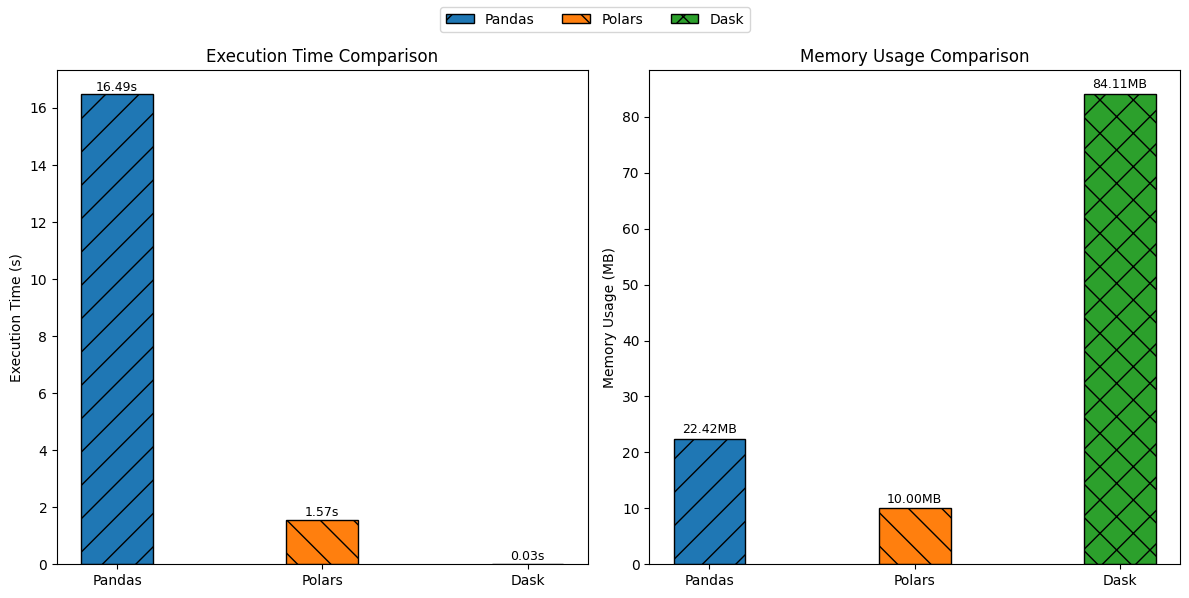

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

libraries = ['Pandas', 'Polars', 'Dask']
execution_times = [pandas_execution_time, polars_execution_time, dask_execution_time]
memory_usages = [pandas_memory_usage_mb, polars_memory_usage_mb, dask_memory_usage_mb]

x = np.arange(len(libraries))  # the label locations
width = 0.35  # the width of the bars
hatches = ['/', '\\', 'x']  # pattern styles

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Execution Time Bar Chart
for i in range(len(libraries)):
    bar = ax[0].bar(x[i], execution_times[i], width, label=libraries[i], hatch=hatches[i], edgecolor='black')
    ax[0].text(x[i], execution_times[i] + 0.01, f'{execution_times[i]:.2f}s', ha='center', va='bottom', fontsize=9)

ax[0].set_ylabel('Execution Time (s)')
ax[0].set_title('Execution Time Comparison')
ax[0].set_xticks(x)
ax[0].set_xticklabels(libraries)

# Memory Usage Bar Chart
for i in range(len(libraries)):
    bar = ax[1].bar(x[i], memory_usages[i], width, label=libraries[i], hatch=hatches[i], edgecolor='black')
    ax[1].text(x[i], memory_usages[i] + 0.5, f'{memory_usages[i]:.2f}MB', ha='center', va='bottom', fontsize=9)

ax[1].set_ylabel('Memory Usage (MB)')
ax[1].set_title('Memory Usage Comparison')
ax[1].set_xticks(x)
ax[1].set_xticklabels(libraries)

# Add a shared legend
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3)

# Layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()